In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Vital Functions Cessation Prediction
Goal: Enabling the prediction of a patient's death based on their biometric and lifestyle parameters. | Cel: Umożliwienie predykcji zgonu pacjenta na podstawie jego parametrów biometrycznych i trybu życia.

In [2]:
# Load data | Wczytywanie danych
dt = pd.read_csv("heart_failure_clinical_records_dataset.csv")
dt["DEATH_EVENT"].value_counts()


DEATH_EVENT
0    203
1     96
Name: count, dtype: int64

In [3]:
# Remove unnecessary attribute | Usunięcie niepotrzebnego atrybutu
dt = dt.drop(["time"], axis=1)

# Check amount of NaN rows | Sprawdzenie ilośći wierszy z wartościami NaN
print(f"Długość kolumn przed usunięciem wierszy z pustymi rubrykami: {len(dt)}")
print(f"Długość kolumn po usunięciu wierszy z pustymi rubrykami: {len(dt.dropna())}")

# dt["platelets_surplus"] = np.where(dt["platelets"] > 450000, 1, 0)
# dt["platelets_shortage"] = np.where(dt["platelets"] < 150000, 1, 0)
# dt["creatinine_phosphokinase_abnormal"] = pd.DataFrame(np.where((dt["creatinine_phosphokinase"] < 40) & (dt["sex"] == 0))) #+ np.where(all([dt["creatinine_phosphokinase"] > 285, dt["sex"] == 0])) + np.where(all([dt["creatinine_phosphokinase"] < 55, dt["sex"] == 1])) + np.where(all([dt["creatinine_phosphokinase"] > 370, dt["sex"] == 1]))

dt["platelets_abnormal"] = np.where(dt["platelets"] > 450000, 1, 0) + np.where(dt["platelets"] < 150000, 1, 0)
dt["creatinine_phosphokinase_abnormal"] = np.where(((dt["creatinine_phosphokinase"] < 40) & (dt["sex"] == 0)) | ((dt["creatinine_phosphokinase"] > 285) & (dt["sex"] == 0)) | ((dt["creatinine_phosphokinase"] < 55) & (dt["sex"] == 1)) | ((dt["creatinine_phosphokinase"] > 370) & (dt["sex"] == 1)), 1, 0)

# Split data to X and y (decision attribute) | Podział danych na X i y (atrybut decydujący)
X = dt.drop(["DEATH_EVENT"], axis=1)
y = dt["DEATH_EVENT"]
X


Długość kolumn przed usunięciem wierszy z pustymi rubrykami: 299
Długość kolumn po usunięciu wierszy z pustymi rubrykami: 299


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,platelets_abnormal,creatinine_phosphokinase_abnormal
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,0,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,0,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,0,0
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,0,0
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,0,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,0,1
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,1,1
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,1,1


In [4]:
# Standarization | Standaryzacja
std = StandardScaler()
std.fit_transform(X, y)


array([[ 1.19294523e+00, -8.71104775e-01,  1.65728387e-04, ...,
        -6.87681906e-01, -3.92988746e-01,  1.07288356e+00],
       [-4.91279276e-01, -8.71104775e-01,  7.51463953e+00, ...,
        -6.87681906e-01, -3.92988746e-01,  1.07288356e+00],
       [ 3.50832977e-01, -8.71104775e-01, -4.49938761e-01, ...,
         1.45416070e+00, -3.92988746e-01, -9.32067594e-01],
       ...,
       [-1.33339153e+00, -8.71104775e-01,  1.52597865e+00, ...,
        -6.87681906e-01,  2.54460213e+00,  1.07288356e+00],
       [-1.33339153e+00, -8.71104775e-01,  1.89039811e+00, ...,
         1.45416070e+00,  2.54460213e+00,  1.07288356e+00],
       [-9.12335403e-01, -8.71104775e-01, -3.98321274e-01, ...,
         1.45416070e+00, -3.92988746e-01, -9.32067594e-01]])

Notatka do projektu:
- 'age' - wiek pacjenta;
- 'anaemia' - spadek liczebności czerwonych krwinek lub chemoglobiny;
- 'creatinine_phosphokinase' - poziom enzymu (kinazy kreatynowej) CPK we krwi (Kinaza kreatynowa jest białkiem, którego podwyższony poziom w surowicy świadczy o tym, że doszło do uszkodzenia komórek o wysokim zapotrzebowaniu na energię.)
https://www.medicover.pl/badania/kinaza-kreatynowa/. W przypadku kinazy kreatynowej (CK) norma dla kobiet wynosi 40-285 U/l a dla mężczyzn 55-370 U/l;
- 'diabetes' - 1 - pacjent jest cukrzykiem, 0 - pacjent nie ma cukrzycy
- 'ejection_fraction' - procent krwi opuszczającej komory sercowe za każdym skurczem
- 'high_blood_pressure' - czy pacjent ma nadciśnienie
- 'platelets' - zawartość płytek we krwi w jednostce platelets/mL (płytki na mikrolitr). A normal platelet count ranges from 150,000 to 450,000 platelets per microliter of blood. Having more than 450,000 platelets is a condition called thrombocytosis; having less than 150,000 is known as thrombocytopenia. You get your platelet number from a routine blood test called a complete blood count (CBC). https://www.hopkinsmedicine.org/health/conditions-and-diseases/what-are-platelets-and-why-are-they-important;
- 'serum_creatinine' - poziom kreatyniny w surowicy we krwi (mg/dL)
- 'serum_sodium' - poziom sodu w surowicy krwi (mEq/L)
- 'sex' - 1 - mężczyzna, 0 - kobieta
- 'smoking' - czy pacjent pali wyroby tytoniowe 1 - tak, 0 - nie
- 'time' - czas w jakim pacjent zmarł po badaniu lub zrezygnował z badania
- 'DEATH_EVENT' - 1 - nastąpił zgon pacjenta, 0 - pacjent żyje lub zrezygnował z badania

<Axes: >

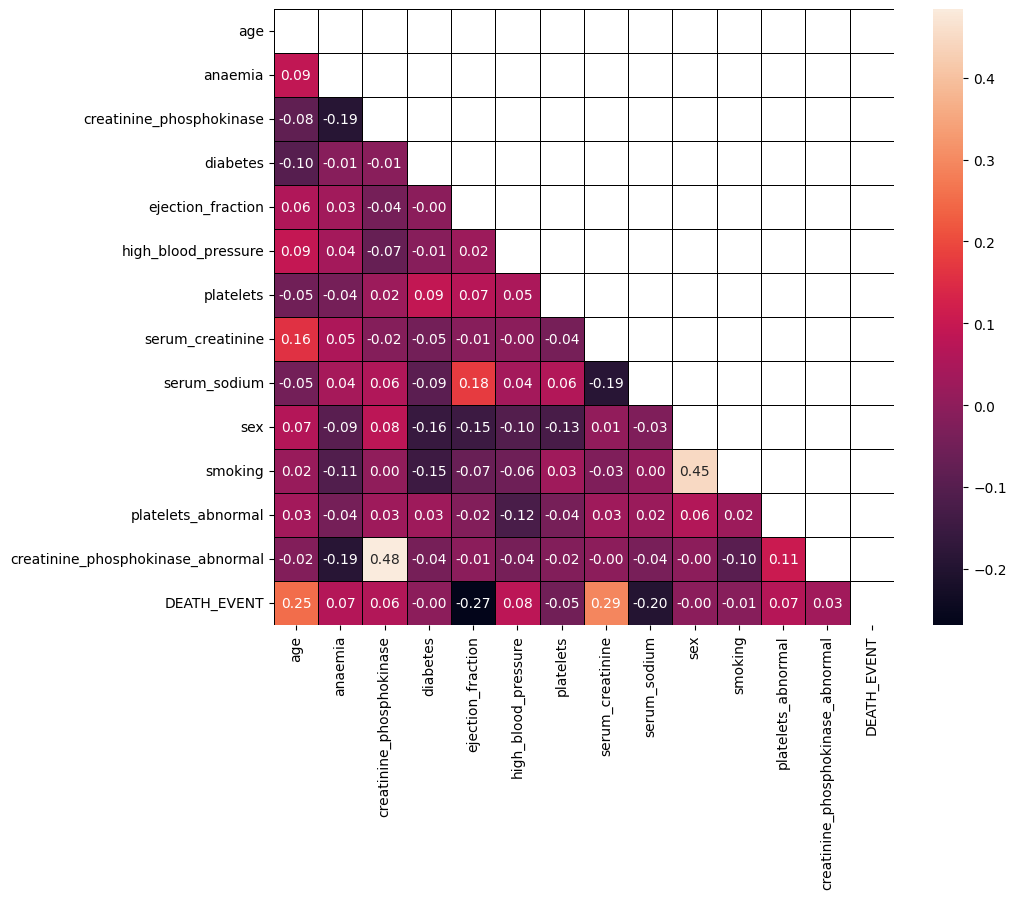

In [5]:
# Correlation heat map visualisation | Wizualizacji mapy ciepła korelacji
corr = X.join(y).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(10, 8))
matrix = np.triu(corr)
sns.heatmap(corr, linewidths=.5, linecolor='black', annot=True, fmt='.2f', mask=matrix)

Text(0.5, 1.0, 'sex')

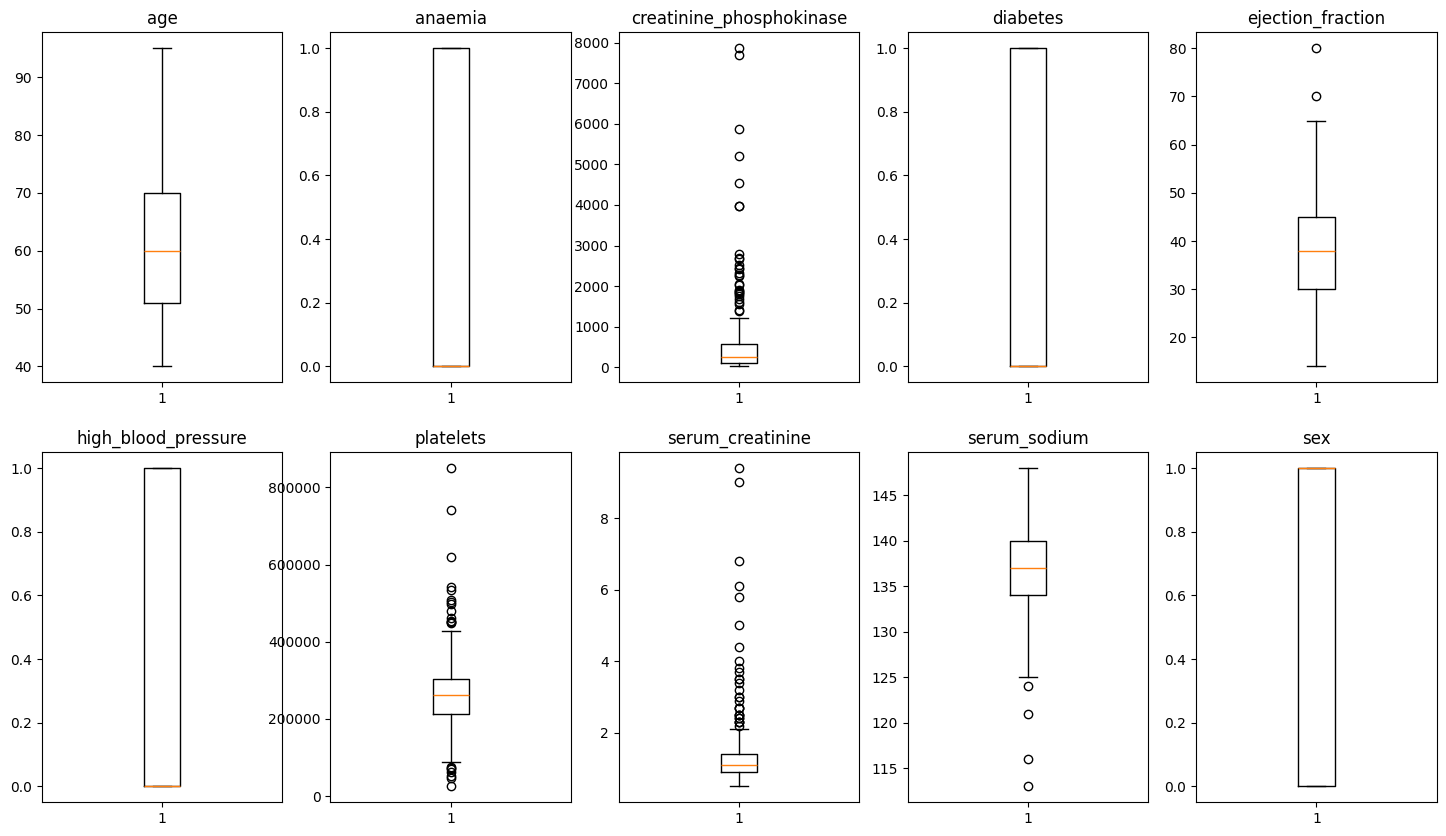

In [6]:
# Data variety visualisation | Wizualizacja odchyleń danych liczbowych
fig, axs = plt.subplots(2, 5, figsize=(18, 10))
axs[0, 0].boxplot(dt['age'])
axs[0, 0].set_title("age")
axs[0, 1].boxplot(dt['anaemia'])
axs[0, 1].set_title("anaemia")
axs[0, 2].boxplot(dt['creatinine_phosphokinase'])
axs[0, 2].set_title("creatinine_phosphokinase")
axs[0, 3].boxplot(dt['diabetes'])
axs[0, 3].set_title("diabetes")
axs[0, 4].boxplot(dt['ejection_fraction'])
axs[0, 4].set_title("ejection_fraction")
axs[1, 0].boxplot(dt['high_blood_pressure'])
axs[1, 0].set_title("high_blood_pressure")
axs[1, 1].boxplot(dt['platelets'])
axs[1, 1].set_title("platelets")
axs[1, 2].boxplot(dt['serum_creatinine'])
axs[1, 2].set_title("serum_creatinine")
axs[1, 3].boxplot(dt['serum_sodium'])
axs[1, 3].set_title("serum_sodium")
axs[1, 4].boxplot(dt['sex'])
axs[1, 4].set_title("sex")

In [6]:
# creatinine_phosphokinase
Q1_creatinine_phosphokinase = np.percentile(dt['creatinine_phosphokinase'], 25, method='linear')
Q3_creatinine_phosphokinase = np.percentile(dt['creatinine_phosphokinase'], 75, method='linear')
IQR_creatinine_phosphokinase = Q3_creatinine_phosphokinase - Q1_creatinine_phosphokinase
upper_treshold_creatinine_phosphokinase = Q3_creatinine_phosphokinase + 1.5 * IQR_creatinine_phosphokinase
lower_treshold_creatinine_phosphokinase = Q1_creatinine_phosphokinase - 1.5 * IQR_creatinine_phosphokinase

# platelets
Q1_platelets = np.percentile(dt['platelets'], 25, method='linear')
Q3_platelets = np.percentile(dt['platelets'], 75, method='linear')
IQR_platelets = Q3_platelets - Q1_platelets
upper_treshold_platelets = Q3_platelets + 1.5 * IQR_platelets
lower_treshold_platelets = Q1_platelets - 1.5 * IQR_platelets

# serum_creatinine
Q1_serum_creatinine = np.percentile(dt['serum_creatinine'], 25, method='linear')
Q3_serum_creatinine = np.percentile(dt['serum_creatinine'], 75, method='linear')
IQR_serum_creatinine = Q3_serum_creatinine - Q1_serum_creatinine
upper_treshold_serum_creatinine = Q3_serum_creatinine + 1.5 * IQR_serum_creatinine
lower_treshold_serum_creatinine = Q1_serum_creatinine - 1.5 * IQR_serum_creatinine

# Cut outstanding values for attributes creatinine_phosphokinase, platelets and serum_creatinine to max range of box plot chart | Ucinanie wartości odstających dla atrybutów creatinine_phosphokinase, platelets i serum_creatinine do zakresu wąsów wykresu pudełkowego
dt['creatinine_phosphokinase'] = dt['creatinine_phosphokinase'].apply(lambda row: Q3_creatinine_phosphokinase if row > Q3_creatinine_phosphokinase else Q1_creatinine_phosphokinase if row < Q1_creatinine_phosphokinase else row)
dt['platelets'] = dt['platelets'].apply(lambda row: Q3_platelets if row > Q3_platelets else Q1_platelets if row < Q1_platelets else row)
dt['serum_creatinine'] = dt['serum_creatinine'].apply(lambda row: Q3_serum_creatinine if row > Q3_serum_creatinine else Q1_serum_creatinine if row < Q1_serum_creatinine else row)

X = dt.drop(["DEATH_EVENT"], axis=1)
y = dt["DEATH_EVENT"]

In [7]:
X_tv, X_test, y_tv, y_test = train_test_split(X,
                                              y,
                                              stratify=y,
                                              test_size=0.20,
                                              random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_tv,
                                                      y_tv,
                                                      stratify=y_tv,
                                                      test_size=0.20,
                                                      random_state=42)


In [9]:
lr = LogisticRegression()
lr_parameters = {'C': list(np.arange(0.01, 1.0, 0.05)), 'max_iter': list(np.arange(50, 300, 50)), "intercept_scaling": list(np.arange(0.01, 1.0, 0.05))} #, 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}
gsc = GridSearchCV(lr, lr_parameters)
gsc.fit(X_valid, y_valid)
print(f"Best params: {gsc.best_params_}")
print(f"Best score: {gsc.best_score_}")
print(f"cross val score: {cross_val_score(lr, X_valid, y_valid, cv=4)}")


c:\Users\sebex\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\sebex\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Best params: {'C': 0.060000000000000005, 'intercept_scaling': 0.01, 'max_iter': 100}
Best score: 0.8111111111111111
cross val score: [0.91666667 0.5        0.75       0.75      ]


In [11]:
# Train Logistic Regression model
# lr = LogisticRegression(C=gsc.best_params_["C"], max_iter=gsc.best_params_["max_iter"], intercept_scaling=gsc.best_params_["intercept_scaling"])
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f"cross val score: {np.mean(cross_val_score(lr, X_valid, y_valid, cv=4))}")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1_score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Classification report:", classification_report(y_test, y_pred))
for yp, yt in zip(y_pred, y_test):
    print(f"Prediction: {yp}, actual value: {yt}")
# Accuracy: 0.7666666666666667
# F1_score: 0.5
# Recall: 0.3684210526315789
# Precision: 0.7777777777777778
# Classification report:               precision    recall  f1-score   support

#            0       0.76      0.95      0.85        41
#            1       0.78      0.37      0.50        19

#     accuracy                           0.77        60
#    macro avg       0.77      0.66      0.67        60
# weighted avg       0.77      0.77      0.74        60

cross val score: 0.7291666666666666
Accuracy: 0.7666666666666667
F1_score: 0.5
Recall: 0.3684210526315789
Precision: 0.7777777777777778
Classification report:               precision    recall  f1-score   support

           0       0.76      0.95      0.85        41
           1       0.78      0.37      0.50        19

    accuracy                           0.77        60
   macro avg       0.77      0.66      0.67        60
weighted avg       0.77      0.77      0.74        60

Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 1
Prediction: 0, actual value: 0
Prediction: 1, actual value: 0
Prediction: 0, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 0, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, act

In [12]:
# Define Decision Tree Classifier parameters to be tested by Grid Search CV
clf = DecisionTreeClassifier(random_state=0)
parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 10]}

path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print("ccp_alphas: \n", ccp_alphas) 


ccp_alphas: 
 [0.         0.00331588 0.00333864 0.00454545 0.00465387 0.00465387
 0.0047993  0.00480164 0.00517719 0.0065445  0.0078534  0.0081219
 0.0083482  0.00837696 0.00837696 0.00837696 0.00846269 0.00897532
 0.00971801 0.01009723 0.01150276 0.01367243 0.03875562 0.05709906]


In [13]:
# Find best Decision Tree Classifier model parameters via Grid Search CV
parameters = {'ccp_alpha': ccp_alphas, 'max_depth': list(range(1, 10, 1)), 'max_leaf_nodes': list(range(2, 10, 1))}
gsc = GridSearchCV(clf, parameters)
gsc.fit(X_valid, y_valid)
print(f"Best params: {gsc.best_params_}")
print(f"Best score: {gsc.best_score_}")
# Best params: {'ccp_alpha': 0.08965157780268407, 'max_depth': 2, 'max_leaf_nodes': 3}
# Best score: 0.8133333333333335

Best params: {'ccp_alpha': 0.0, 'max_depth': 2, 'max_leaf_nodes': 3}
Best score: 0.7488888888888888


In [14]:
# Train best Desicion Tree Classifier model
clf = DecisionTreeClassifier(random_state=42, ccp_alpha=gsc.best_params_["ccp_alpha"], max_depth=gsc.best_params_["max_depth"], max_leaf_nodes=gsc.best_params_["max_leaf_nodes"])
print(f"cross val score: {cross_val_score(clf, X_valid, y_valid, cv=4)}")
print(f"mean: {np.mean(cross_val_score(clf, X_valid, y_valid, cv=4))}")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1_score: {f1_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
for yp, yt in zip(y_pred, y_test):
    print(f"Prediction: {yp}, actual value: {yt}")

cross val score: [0.83333333 0.58333333 0.75       0.75      ]
mean: 0.7291666666666667
Accuracy: 0.6666666666666666
F1_score: 0.5238095238095238
Recall: 0.5789473684210527
Precision: 0.4782608695652174
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 1, actual value: 0
Prediction: 1, actual value: 0
Prediction: 0, actual value: 0
Prediction: 1, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 1
Prediction: 0, actual value: 0
Prediction: 1, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 1
Prediction: 0, actual value: 0
Prediction: 0, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 1
Prediction: 1, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 1, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 1, actual 

In [ ]:
# Find best SVC model parameters via Grid Search CV
svc = SVC() # model osiąga wysokie wyniki lecz poprzez przyjmowanie samych wartości "0"
svc_parameters = {'C': list(np.arange(0.01, 0.03, 0.01)), 'kernel': ["linear"]} #, "poly", "rbf", "sigmoid"]}
gsc = GridSearchCV(svc, svc_parameters)
gsc.fit(X_valid, y_valid)
print(f"Best params: {gsc.best_params_}")
print(f"Best score: {gsc.best_score_}")
print(f"cross val score: {np.mean(cross_val_score(svc, X_valid, y_valid, cv=4))}")
# Best params: {'C': 0.03, 'kernel': 'linear'}
# Best score: 0.8133333333333335
# cross val score: [0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  1.   0.75]

In [ ]:
# Train best SVC model
svc = SVC(random_state=42, C=gsc.best_params_["C"], kernel=gsc.best_params_["kernel"])
print(f"cross val score: {cross_val_score(svc, X_valid, y_valid, cv=4)}")
print(f"mean: {np.mean(cross_val_score(svc, X_valid, y_valid, cv=4))}")
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1_score: {f1_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
for yp, yt in zip(y_pred, y_test):
    print(f"Prediction: {yp}, actual value: {yt}")

In [8]:
# Train Random Forest Classifier model
rfc = RandomForestClassifier(random_state=42, max_leaf_nodes=10)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(f"cross val score: {np.mean(cross_val_score(rfc, X_valid, y_valid, cv=4))}")
print(f"Accuracy_score: {accuracy_score(y_test, y_pred)}")
print(f"F1_score: {f1_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
for yp, yt in zip(y_pred, y_test):
    print(f"Prediction: {yp}, actual value: {yt}")

cross val score: 0.7291666666666667
Accuracy_score: 0.75
F1_score: 0.44444444444444436
Recall: 0.3157894736842105
Precision: 0.75
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 1
Prediction: 0, actual value: 0
Prediction: 1, actual value: 0
Prediction: 1, actual value: 1
Prediction: 0, actual value: 1
Prediction: 0, actual value: 1
Prediction: 0, actual value: 0
Prediction: 0, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 1
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 1
Pr